# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [1]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [2]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter, mode='valid')
filterResponseSobelX = signal.convolve2d(image, sobelX, mode='valid')
filterResponseSobelY = signal.convolve2d(image, sobelY, mode='valid')

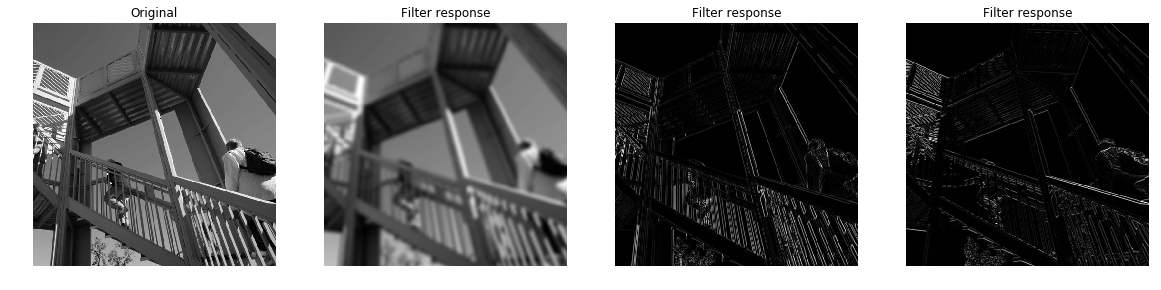

In [4]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?
- Gaussian: Remove details and noise.
- SobelX: Detect edges along axis y.
- SobelY: Detect edges along axis x.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?
- (512,512)
- It has 1 channel.
- Color images have 3 channels (RGB).

Question 3: What is the size of the different filters?
- Gaussian: (15,15).
- SobelX: (3,3).
- SobelY: (3,3).

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?
- Gaussian: (512,512).
- SobelX: (512,512).
- SobelY: (512,512).

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter?
- Gaussian: (498,498).
- SobelX: (510,510).
- SobelY: (510,510).

The filter response will be (Nf -1) pixels smaller (Nf size of filter).

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?
- We can eventually run out of pixels as the image will get smaller in every layer.



In [5]:
# Your code for checking sizes of image and filter response
np.shape(gaussFilter)
np.shape(sobelX)
np.shape(sobelY)
np.shape(filterResponseGauss)
np.shape(filterResponseSobelX)
np.shape(filterResponseSobelY)

(510, 510)

##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [6]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 
- Because the filter size is (7,7) as set and there are 3 input channels. 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?
- A convolutional kernel is created that is convolved with the layer input to produce a tensor of outputs. In signal.convolve2d what is performed is a scalar product between the input and the filter.

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?
- The GPU is 6 times faster than the CPU.

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

- The CPU IS as fast as the GPU. This is because with 1000 images the GPU can process more of them at once because of the its multiple cores, while the CPU can process less at the same time. However, with a smaller batch, both CPU and GPU process the same amount of images at the same time making the difference in performance smaller.  

In [7]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.07645248799997262
GPU (s):
0.055087835999984236
GPU speedup over CPU: 1x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [8]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

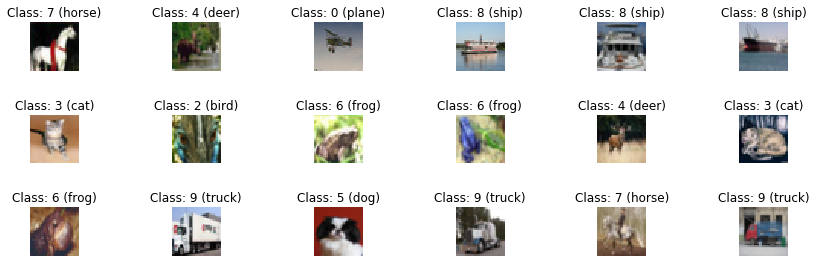

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25)

# Print the size of training data, validation data and test data
print('The train, validation and test data have size {}, {}, {}, {}, {} and {}'.format(Xtrain.shape, Xval.shape, Xtest.shape, 
                                                                               Ytrain.shape, Yval.shape, Ytest.shape))

The train, validation and test data have size (7500, 32, 32, 3), (2500, 32, 32, 3), (2000, 32, 32, 3), (7500, 1), (2500, 1) and (2000, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [11]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [12]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('Before converting the labels')
print(' - Ytrain has size {}.'.format(Ytrain.shape))
print(' - Yval has size {}.'.format(Yval.shape))
print(' - Ytest has size {}.'.format(Ytest.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain=to_categorical(Ytrain, num_classes=10, dtype='float32')
Yval=to_categorical(Yval, num_classes=10, dtype='float32')
Ytest=to_categorical(Ytest, num_classes=10, dtype='float32')

# Print shapes after converting the labels
print('\nAfter converting the labels')
print(' - Ytrain has size {}.'.format(Ytrain.shape))
print(' - Yval has size {}.'.format(Yval.shape))
print(' - Ytest has size {}.'.format(Ytest.shape))


Before converting the labels
 - Ytrain has size (7500, 1).
 - Yval has size (2500, 1).
 - Ytest has size (2000, 1).

After converting the labels
 - Ytrain has size (7500, 10).
 - Yval has size (2500, 10).
 - Ytest has size (2000, 10).


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [13]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        model.add(Conv2D(filters=n_filters*(2**(i+1)), kernel_size=(3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add flatten layer
    model.add(Flatten())
    
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(units=n_nodes, activation='relu'))
        model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))
        
    # Add final dense layer
    model.add(Dense(10, activation = 'softmax'))
   
    # Compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = learning_rate), metrics=['accuracy'])
    
    return model

In [14]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [26]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model1 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16,
                   n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = (Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 260us/step - loss: 2.8738 - accuracy: 0.3327 - val_loss: 2.0390 - val_accuracy: 0.3156
Epoch 2/20
7500/7500 [==============================] - 1s 137us/step - loss: 1.5891 - accuracy: 0.4737 - val_loss: 1.6202 - val_accuracy: 0.4112
Epoch 3/20
7500/7500 [==============================] - 1s 138us/step - loss: 1.2557 - accuracy: 0.5548 - val_loss: 1.5942 - val_accuracy: 0.4456
Epoch 4/20
7500/7500 [==============================] - 1s 136us/step - loss: 1.1082 - accuracy: 0.6051 - val_loss: 1.3956 - val_accuracy: 0.5016
Epoch 5/20
7500/7500 [==============================] - 1s 137us/step - loss: 0.9975 - accuracy: 0.6455 - val_loss: 1.3083 - val_accuracy: 0.5384
Epoch 6/20
7500/7500 [==============================] - 1s 137us/step - loss: 0.8989 - accuracy: 0.6873 - val_loss: 1.2619 - val_accuracy: 0.5612
Epoch 7/20
7500/7500 [==============================] - 1s 137us/step - loss

In [50]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 63us/step
Test loss: 2.9182
Test accuracy: 0.5430


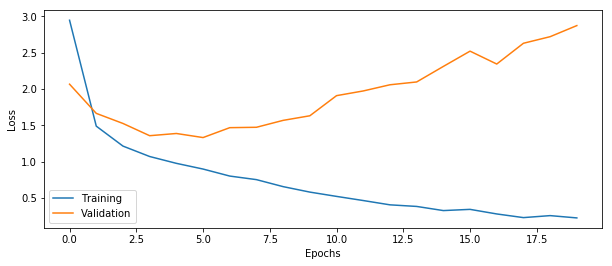

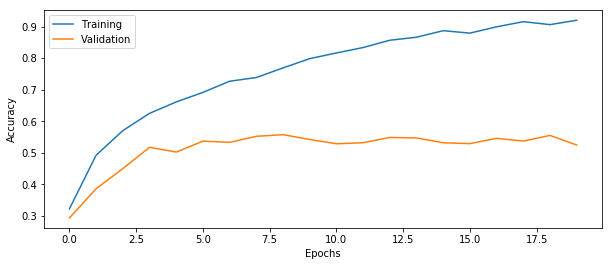

In [51]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ?
- The accuracy obtained in the first test is 0.5430. It can be improved a lot. 

Question 11: How big is the difference between training and test accuracy?
- Training accuracy is 0.9199. The difference between training and test is 0.3769.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

- The GPU is 75% busy, using 11036 MB.

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

- Images take up more memory and with a batch size off 10,000 they wouldn't fit in the GPU.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [53]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model2 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16,
                   n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)


# Train the model  using training data and validation data
history2 = model2.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = (Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 2s - loss: 1.6154 - accuracy: 0.4183 - val_loss: 1.8686 - val_accuracy: 0.3056
Epoch 2/20
 - 1s - loss: 1.2466 - accuracy: 0.5527 - val_loss: 2.4132 - val_accuracy: 0.2136
Epoch 3/20
 - 1s - loss: 1.0726 - accuracy: 0.6175 - val_loss: 1.6566 - val_accuracy: 0.4352
Epoch 4/20
 - 1s - loss: 0.8698 - accuracy: 0.6943 - val_loss: 1.3117 - val_accuracy: 0.5384
Epoch 5/20
 - 1s - loss: 0.7075 - accuracy: 0.7527 - val_loss: 1.4052 - val_accuracy: 0.5392
Epoch 6/20
 - 1s - loss: 0.5513 - accuracy: 0.8083 - val_loss: 1.5271 - val_accuracy: 0.5640
Epoch 7/20
 - 1s - loss: 0.4104 - accuracy: 0.8591 - val_loss: 1.7178 - val_accuracy: 0.5668
Epoch 8/20
 - 1s - loss: 0.2903 - accuracy: 0.8989 - val_loss: 2.0588 - val_accuracy: 0.5600
Epoch 9/20
 - 1s - loss: 0.2391 - accuracy: 0.9205 - val_loss: 2.0479 - val_accuracy: 0.5700
Epoch 10/20
 - 1s - loss: 0.1770 - accuracy: 0.9391 - val_loss: 2.1324 - val_accuracy: 0.5836
Epoch 11/20
 - 1s - l

In [54]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 68us/step
Test loss: 3.0422
Test accuracy: 0.5415


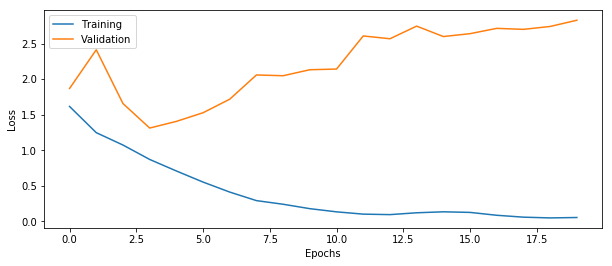

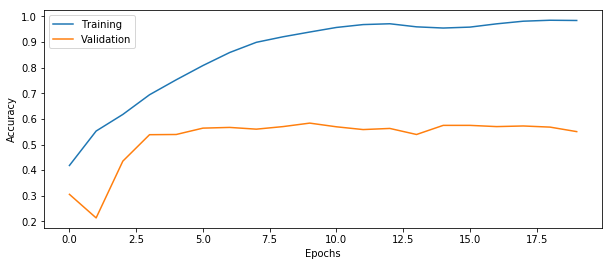

In [55]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [57]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16,
                   n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = (Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 3s - loss: 1.7383 - accuracy: 0.3735 - val_loss: 1.9235 - val_accuracy: 0.3404
Epoch 2/20
 - 2s - loss: 1.3836 - accuracy: 0.4923 - val_loss: 1.8782 - val_accuracy: 0.3552
Epoch 3/20
 - 2s - loss: 1.1738 - accuracy: 0.5749 - val_loss: 1.5546 - val_accuracy: 0.4760
Epoch 4/20
 - 2s - loss: 1.0180 - accuracy: 0.6341 - val_loss: 1.3382 - val_accuracy: 0.5468
Epoch 5/20
 - 2s - loss: 0.8690 - accuracy: 0.6905 - val_loss: 1.3821 - val_accuracy: 0.5824
Epoch 6/20
 - 2s - loss: 0.7159 - accuracy: 0.7465 - val_loss: 1.7108 - val_accuracy: 0.5432
Epoch 7/20
 - 2s - loss: 0.5906 - accuracy: 0.7903 - val_loss: 1.7685 - val_accuracy: 0.5756
Epoch 8/20
 - 2s - loss: 0.4598 - accuracy: 0.8357 - val_loss: 1.7969 - val_accuracy: 0.5780
Epoch 9/20
 - 2s - loss: 0.3501 - accuracy: 0.8743 - val_loss: 1.8675 - val_accuracy: 0.5820
Epoch 10/20
 - 2s - loss: 0.2746 - accuracy: 0.9017 - val_loss: 1.9925 - val_accuracy: 0.6028
Epoch 11/20
 - 2s - l

In [58]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 86us/step
Test loss: 2.8451
Test accuracy: 0.5805


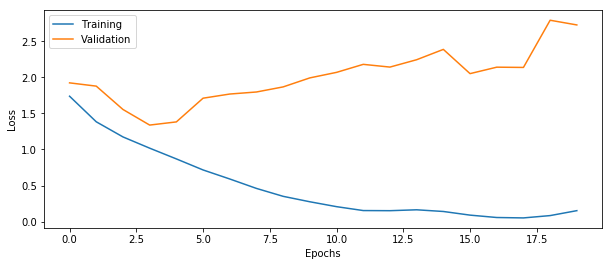

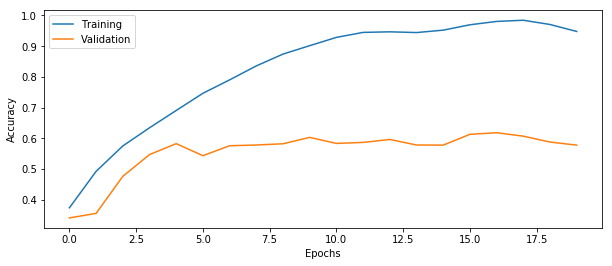

In [59]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?
- 124,180. The 4th convolutional layer with 73,856 parameters.

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 
- Input: a 4D tensor with dimensions (batch_size, channels, rows, columns)
- Output: a 4D tensor with dimensions (batch_size, filters, new_rows, new_columns)

If the data format is channels first.

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/
- Yes

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?
- 128

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?
- It is the number of channels in the previous layer times the number of filter coefficients per filter plus biases.

Question 19: How does MaxPooling help in reducing the number of parameters to train?
- For every patch/filter it takes the maximum number and use it as an output for the whole patch. 

In [60]:
# Print network architecture

model3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)        

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?
- With the same number of convolutional and dense layers, the accuracy with dropout improved 0.0155.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?
- L1 or L2, for instance, can be applied as regularization techniques. 
- When creating the Convolutional layer we should add the argument "kernel_regularizer=keras.regularizers.l2(i)" being "i" the regularization factor.


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [62]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16,
                   n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = (Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 3s - loss: 1.9689 - accuracy: 0.3065 - val_loss: 1.8760 - val_accuracy: 0.3288
Epoch 2/20
 - 2s - loss: 1.5421 - accuracy: 0.4248 - val_loss: 1.9267 - val_accuracy: 0.3272
Epoch 3/20
 - 2s - loss: 1.3790 - accuracy: 0.4907 - val_loss: 1.6083 - val_accuracy: 0.4648
Epoch 4/20
 - 2s - loss: 1.2602 - accuracy: 0.5383 - val_loss: 1.4164 - val_accuracy: 0.4920
Epoch 5/20
 - 2s - loss: 1.1518 - accuracy: 0.5787 - val_loss: 1.3510 - val_accuracy: 0.5280
Epoch 6/20
 - 2s - loss: 1.0662 - accuracy: 0.6183 - val_loss: 1.3361 - val_accuracy: 0.5476
Epoch 7/20
 - 2s - loss: 0.9607 - accuracy: 0.6628 - val_loss: 1.3564 - val_accuracy: 0.5708
Epoch 8/20
 - 2s - loss: 0.8798 - accuracy: 0.6891 - val_loss: 1.5121 - val_accuracy: 0.5412
Epoch 9/20
 - 2s - loss: 0.7666 - accuracy: 0.7281 - val_loss: 1.4368 - val_accuracy: 0.5704
Epoch 10/20
 - 2s - loss: 0.6812 - accuracy: 0.7579 - val_loss: 1.4012 - val_accuracy: 0.6128
Epoch 11/20
 - 2s - l

In [63]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 80us/step
Test loss: 2.1356
Test accuracy: 0.5960


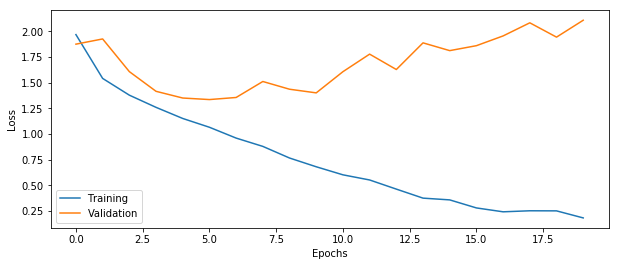

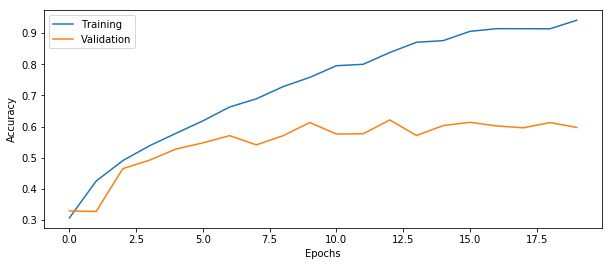

In [64]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

Test data accuracy with best config: 63.45%

Best config: 

batch size = 10

epochs = 15

number of conv layers = 3,

number of filters = 32,

number of dense layers = 1,

number of nodes per dense layer = 50,

activation function = relu,

optimizer = Adam,

learning rate = 0.007,

Dropout.

## Your best config

In [21]:
# Setup some training parameters
batch_size = 10
epochs = 15
input_shape = Xtrain.shape[1:]

# Build model
model5 = build_CNN(input_shape=input_shape, n_conv_layers=3, n_filters=32,
                   n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.007)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = (Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/15
 - 9s - loss: 1.9690 - accuracy: 0.2984 - val_loss: 1.7474 - val_accuracy: 0.3584
Epoch 2/15
 - 8s - loss: 1.6854 - accuracy: 0.3773 - val_loss: 1.4803 - val_accuracy: 0.4560
Epoch 3/15
 - 8s - loss: 1.5514 - accuracy: 0.4353 - val_loss: 1.4851 - val_accuracy: 0.4632
Epoch 4/15
 - 8s - loss: 1.5002 - accuracy: 0.4596 - val_loss: 1.4237 - val_accuracy: 0.4860
Epoch 5/15
 - 8s - loss: 1.4113 - accuracy: 0.4957 - val_loss: 1.2604 - val_accuracy: 0.5424
Epoch 6/15
 - 8s - loss: 1.2794 - accuracy: 0.5456 - val_loss: 1.1470 - val_accuracy: 0.5928
Epoch 7/15
 - 8s - loss: 1.2234 - accuracy: 0.5705 - val_loss: 1.1655 - val_accuracy: 0.5792
Epoch 8/15
 - 8s - loss: 1.1790 - accuracy: 0.5915 - val_loss: 1.0807 - val_accuracy: 0.6236
Epoch 9/15
 - 8s - loss: 1.1104 - accuracy: 0.6139 - val_loss: 1.1238 - val_accuracy: 0.6128
Epoch 10/15
 - 8s - loss: 1.0220 - accuracy: 0.6472 - val_loss: 1.0694 - val_accuracy: 0.6172
Epoch 11/15
 - 8s - l

In [24]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 1s 368us/step
Test loss: 1.1192
Test accuracy: 0.6345


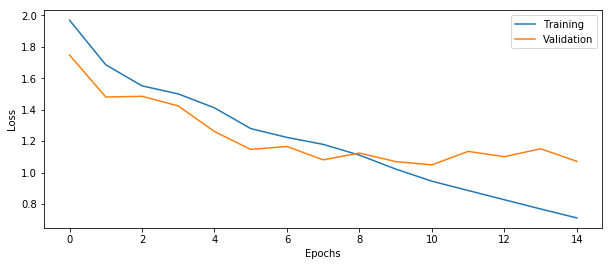

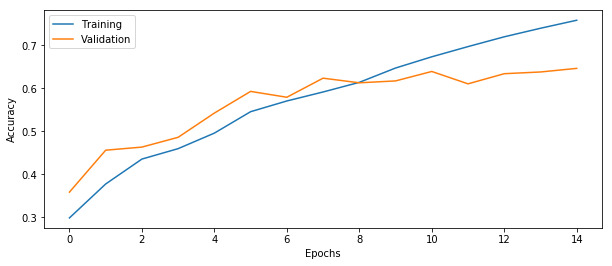

In [25]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.
- The test accuracy for rotated images is 0.2195. This is due the network has not been trained with rotated images, therefore it is difficult to classify properly this images. 

In [26]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

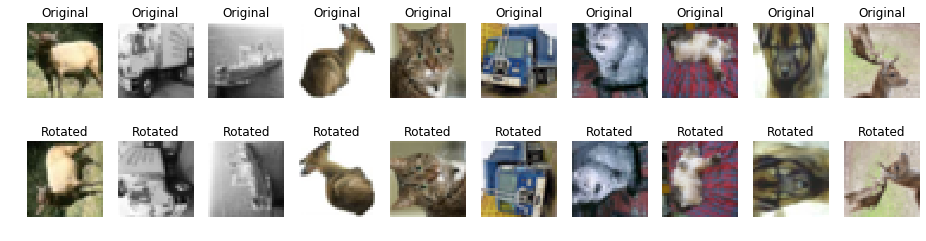

In [27]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [29]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated, Ytest, batch_size = batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 1s 373us/step
Test loss: 3.4494
Test accuracy: 0.2195


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [30]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [31]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=True, validation_split=0.2)


# Setup a flow for training data, assume that we can fit all images into CPU memory
Xtrain_flow = datagen.flow(x=Xtrain, y=Ytrain, batch_size=100, subset="training")

# Setup a flow for validation data, assume that we can fit all images into CPU memory
Xval_flow = datagen.flow(x=Xtrain, y=Ytrain, batch_size=100, subset="validation")

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?
- Instead of .flow(), we could use .flow_from_directory() or .flow_from_dataframe() methods to load training data from a disk or dataframe. This would mean that the CPU has to copy data from outside the chip to its memory, which can get very slow.


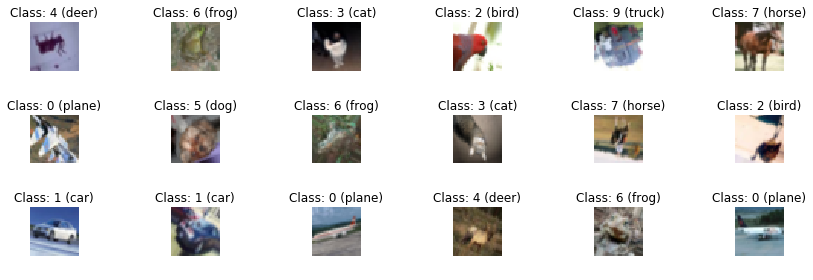

In [32]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?
- With augmentaton the training accuracy increases much slower. This is because the transformation of the original data is done on the CPU, which is much slower than the GPU. In order to perform more training we would have to increase the number of epochs.

Question 26: What other types of image augmentation can be applied, compared to what we use here?
- There are many types od image augmentation. We can enumerate some of them:
    - Flatten or heighten the image.
    - Modify the brightness.
    - Modify the shear intensity.
    - Zoom images.
    - Rescale images.

In [33]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

# Build model (your best config)
model6 = build_CNN(input_shape=input_shape, n_conv_layers=3, n_filters=32,
                   n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.007)

validation_split=0.2
steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size
validation_steps=len(Xtrain)*validation_split/batch_size
    
# Train the model using on the fly augmentation
history6 = model6.fit_generator(Xtrain_flow, steps_per_epoch=steps_per_epoch, epochs = epochs,
                                verbose = 2, validation_steps=validation_steps, validation_data = Xval_flow)

Epoch 1/200
 - 5s - loss: 2.1180 - accuracy: 0.2598 - val_loss: 2.0978 - val_accuracy: 0.2195
Epoch 2/200
 - 4s - loss: 1.7228 - accuracy: 0.3649 - val_loss: 2.4164 - val_accuracy: 0.1940
Epoch 3/200
 - 4s - loss: 1.6494 - accuracy: 0.3926 - val_loss: 1.9487 - val_accuracy: 0.2895
Epoch 4/200
 - 4s - loss: 1.5751 - accuracy: 0.4169 - val_loss: 1.8142 - val_accuracy: 0.3480
Epoch 5/200
 - 4s - loss: 1.5238 - accuracy: 0.4353 - val_loss: 1.3758 - val_accuracy: 0.4690
Epoch 6/200
 - 4s - loss: 1.4952 - accuracy: 0.4509 - val_loss: 1.4670 - val_accuracy: 0.4800
Epoch 7/200
 - 4s - loss: 1.4530 - accuracy: 0.4681 - val_loss: 1.2203 - val_accuracy: 0.4790
Epoch 8/200
 - 4s - loss: 1.4099 - accuracy: 0.4816 - val_loss: 1.2813 - val_accuracy: 0.4725
Epoch 9/200
 - 4s - loss: 1.3743 - accuracy: 0.5014 - val_loss: 1.6070 - val_accuracy: 0.4795
Epoch 10/200
 - 4s - loss: 1.3533 - accuracy: 0.5088 - val_loss: 1.4041 - val_accuracy: 0.5235
Epoch 11/200
 - 4s - loss: 1.3202 - accuracy: 0.5239 - val_

Epoch 88/200
 - 4s - loss: 0.6997 - accuracy: 0.7561 - val_loss: 1.2578 - val_accuracy: 0.6365
Epoch 89/200
 - 4s - loss: 0.7125 - accuracy: 0.7596 - val_loss: 1.0220 - val_accuracy: 0.6455
Epoch 90/200
 - 4s - loss: 0.7057 - accuracy: 0.7529 - val_loss: 1.1529 - val_accuracy: 0.6485
Epoch 91/200
 - 4s - loss: 0.7032 - accuracy: 0.7527 - val_loss: 1.2042 - val_accuracy: 0.6550
Epoch 92/200
 - 4s - loss: 0.7037 - accuracy: 0.7566 - val_loss: 1.1545 - val_accuracy: 0.6515
Epoch 93/200
 - 4s - loss: 0.6935 - accuracy: 0.7579 - val_loss: 0.9548 - val_accuracy: 0.6285
Epoch 94/200
 - 4s - loss: 0.6709 - accuracy: 0.7690 - val_loss: 1.1575 - val_accuracy: 0.6440
Epoch 95/200
 - 4s - loss: 0.6839 - accuracy: 0.7611 - val_loss: 0.8753 - val_accuracy: 0.6660
Epoch 96/200
 - 4s - loss: 0.6966 - accuracy: 0.7545 - val_loss: 0.8205 - val_accuracy: 0.6500
Epoch 97/200
 - 4s - loss: 0.6873 - accuracy: 0.7581 - val_loss: 1.1413 - val_accuracy: 0.6395
Epoch 98/200
 - 4s - loss: 0.6764 - accuracy: 0.75

Epoch 174/200
 - 4s - loss: 0.5466 - accuracy: 0.8089 - val_loss: 1.0602 - val_accuracy: 0.6730
Epoch 175/200
 - 4s - loss: 0.5243 - accuracy: 0.8173 - val_loss: 1.1181 - val_accuracy: 0.6630
Epoch 176/200
 - 4s - loss: 0.5097 - accuracy: 0.8202 - val_loss: 1.2896 - val_accuracy: 0.6565
Epoch 177/200
 - 4s - loss: 0.5367 - accuracy: 0.8171 - val_loss: 1.4257 - val_accuracy: 0.6835
Epoch 178/200
 - 4s - loss: 0.5281 - accuracy: 0.8184 - val_loss: 1.0572 - val_accuracy: 0.6755
Epoch 179/200
 - 4s - loss: 0.5178 - accuracy: 0.8204 - val_loss: 1.0101 - val_accuracy: 0.6760
Epoch 180/200
 - 4s - loss: 0.5269 - accuracy: 0.8154 - val_loss: 0.9846 - val_accuracy: 0.6600
Epoch 181/200
 - 4s - loss: 0.5305 - accuracy: 0.8200 - val_loss: 1.2672 - val_accuracy: 0.6680
Epoch 182/200
 - 4s - loss: 0.5184 - accuracy: 0.8190 - val_loss: 1.3295 - val_accuracy: 0.6615
Epoch 183/200
 - 4s - loss: 0.5236 - accuracy: 0.8194 - val_loss: 0.8787 - val_accuracy: 0.6540
Epoch 184/200
 - 4s - loss: 0.5301 - acc

In [34]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.1431
Test accuracy: 0.6790
Test loss: 3.0951
Test accuracy: 0.3175


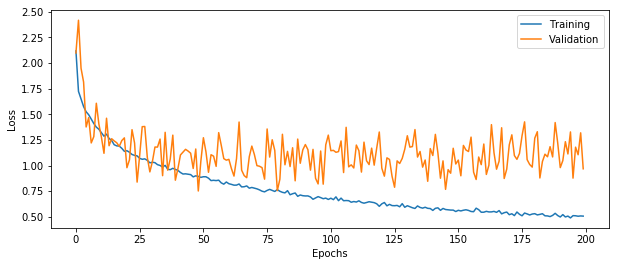

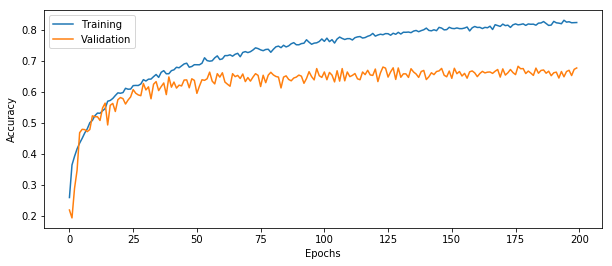

In [35]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [36]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

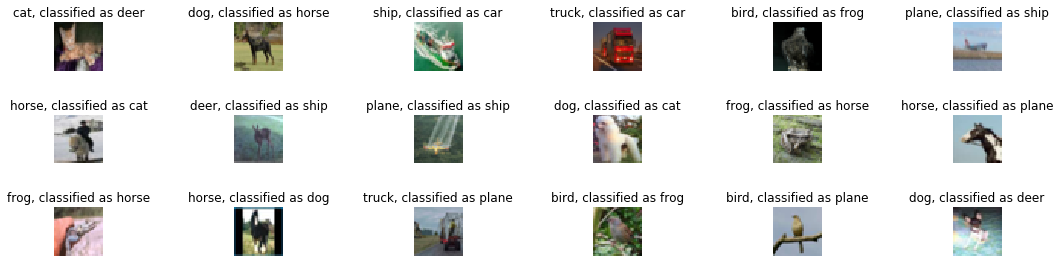

In [37]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?
- No. This is because the architecture of the CNN depends on the input size.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?
- Yes. It can be done reshaping or cropping the image beforehand, or using fully convolutional networks. 

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 
- 48 convolutional layers.

Question 30: How many trainable parameters does the ResNet50 network have?
- 25,583,592

Question 31: What is the size of the images that ResNet50 expects as input?
- (224,224) pixels

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.
-  The Hessian matrix would be too large and time consuming to compute it and its inverse.</font>

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?
- Yes, the perdictions are mostly correct, but the network failed to recognise a cat that is sitting in the grass. The highest certainty is of 97% for the 2 cars (but different types) and the lowest is of 47% (for the cat that was classified as a collie). The dog got classified with a certainty of 83% (it was a different breed, though). The bird had a certainty of 80% and the type of bird was correct, too. 

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [38]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice

ResNet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

In [39]:
ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
#this code was copied and modified from the Keras documentation website
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


img_path = 'CNN/car.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04285008', 'sports_car', 0.9723247), ('n02974003', 'car_wheel', 0.01933042), ('n03459775', 'grille', 0.0026934)]


In [41]:
img_path = 'CNN/f1_car.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04037443', 'racer', 0.97207075), ('n04285008', 'sports_car', 0.016116323), ('n03444034', 'go-kart', 0.0068430384)]


In [42]:
img_path = 'CNN/dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02113799', 'standard_poodle', 0.8305536), ('n02093647', 'Bedlington_terrier', 0.16157037), ('n02088094', 'Afghan_hound', 0.0018747604)]


In [43]:
img_path = 'CNN/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02106030', 'collie', 0.4356203), ('n02119789', 'kit_fox', 0.2174902), ('n02105855', 'Shetland_sheepdog', 0.059867267)]


In [44]:
img_path = 'CNN/bird.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01833805', 'hummingbird', 0.79822695), ('n01843065', 'jacamar', 0.19272268), ('n01806143', 'peacock', 0.007216078)]
